# Visualise distribution of Computational Neuroscience around the globe

## Install dependencies

In [1]:
!rm requirements.txt
!echo "requests\nrequests-xml\npandas\nbokeh\nseaborn\nsvgutils\nselenium" >> requirements.txt
!python -m pip install -r requirements.txt

## Imports

In [2]:
%matplotlib notebook
import sys
assert sys.version_info.major>=3 and sys.version_info.minor>=6, "must be version >= 3.6 for format string literals and requests-xml"
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from requests_xml import XMLSession
requests = XMLSession()

## Figure settings

In [3]:
from collections import namedtuple
from matplotlib import rcParams

class settings(object):
    SMALLEST_SIZE = 6
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    LARGE_SIZE = 12
    BIGGER_SIZE = 14
    BIGGEST_SIZE = 18
    FIG_SIZE = (16, 10)
    FIG_RES_ADJUST = 1  # or 4 for 4K

def set_figure_dpi(dpi=None, figure_formats=['png2x']):
    """Set resolution and format of figures.

    Parameters
    ----------
    dpi : int, optional
        Resolution of png output in dots per inch.
    figure_formats : list of strings
        Only concerns the IPython environment; see
        `IPython.core.display.set_matplotlib_formats` for more details. For
        setting the default format for saving figures, directly set
        `file_format_figs`.
    """
    try:
        import IPython
        IPython.core.display.set_matplotlib_formats(*figure_formats)
    except:
        pass
    global _dpi
    if dpi is not None: _dpi = dpi
    # need to set the following two lines as older Jupyter notebooks seem to use
    # 'savefig.dpi' and more rescent ones 'figure.dpi'
    rcParams['savefig.dpi'] = _dpi
    rcParams['figure.dpi'] = _dpi

rcParams['pdf.fonttype'] = 42  # Output Type 3 (Type3) or Type 42 (TrueType)
plt.rc('font', family='sans serif', size=settings.MEDIUM_SIZE)  # controls default text sizes
rcParams['text.latex.unicode'] = True
rcParams['axes.titlesize'] = settings.BIGGEST_SIZE  # fontsize of the axes title
rcParams['axes.labelsize'] = settings.BIGGEST_SIZE  # fontsize of the x and y labels
rcParams['xtick.labelsize'] = settings.BIGGER_SIZE  # fontsize of the tick labels
rcParams['ytick.labelsize'] = settings.LARGE_SIZE  # fontsize of the tick labels
rcParams['legend.fontsize'] = settings.BIGGEST_SIZE  # legend fontsize
rcParams['figure.titlesize'] = settings.BIGGEST_SIZE  # fontsize of the figure title
rcParams['axes.linewidth'] = 2
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 2
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1
set_figure_dpi(settings.FIG_RES_ADJUST * rcParams['figure.dpi'])

/opt/anaconda/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


## Define search terms

In [4]:
all_comp_search_term = '(computational OR mathematical OR theoretical) AND neuroscience'.replace(" ","+")
all_neuro_search_term = 'neuroscience'

## Globals

In [5]:
force_search = False # ignores presence of file
file_name = "comp_neuro_viz_data.csv"
file_exists = os.path.exists(file_name) and not force_search
file_exists

True

## Load country codes from a csv file

data is from https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes

In [6]:
country_codes = pd.read_csv("https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/raw/master/all/all.csv")
# fix NAMIBIA and USA
country_codes = country_codes.fillna("NA")
# USA exception: https://www.nlm.nih.gov/bsd/mms/medlineelements.html#ad
country_codes['alpha-2'] = country_codes['alpha-2'].replace('US','USA')

country_codes['name'] = country_codes['name'].replace('United States of America','USA')
country_codes['name'] = country_codes['name'].replace('United Kingdom of Great Britain and Northern Ireland',
                                                      'UK')
country_codes['name'] = country_codes['name'].replace("Lao People's Democratic Republic","Laos")
# remove parentheses
country_codes['name'] = country_codes['name'].str.replace(r"\(.*\)","")
country_codes

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NA,142,34,NA
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NA,150,154,NA
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NA,150,39,NA
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NA,2,15,NA
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NA,9,61,NA
5,Andorra,AD,AND,20,ISO 3166-2:AD,Europe,Southern Europe,NA,150,39,NA
6,Angola,AO,AGO,24,ISO 3166-2:AO,Africa,Sub-Saharan Africa,Middle Africa,2,202,17
7,Anguilla,AI,AIA,660,ISO 3166-2:AI,Americas,Latin America and the Caribbean,Caribbean,19,419,29
8,Antarctica,AQ,ATA,10,ISO 3166-2:AQ,NA,NA,NA,NA,NA,NA
9,Antigua and Barbuda,AG,ATG,28,ISO 3166-2:AG,Americas,Latin America and the Caribbean,Caribbean,19,419,29


## Function to get number of results from PubMed for a given search term

In [7]:
base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term="
def get_number_results_from_pubmed(base_search_term, country_name=None, _num_tries=0):
    try:
        if country_name is None:
            result = requests.get(f'{base_url}{base_search_term}')
        else:
            result = requests.get(f'{base_url}{base_search_term}+AND+("{country_name}"[ad]')
    except Exception as e:
        import time
        print(_num_tries, end=' ')
        if _num_tries>10:
            raise
        else:
            time.sleep(1) # pause for 1 sec
            return get_number_results_from_pubmed(base_search_term, 
                                                  country_name=country_name, 
                                                  _num_tries=_num_tries+1)
    assert result.status_code == 200, print(r)
    return int(result.xml.xpath("//eSearchResult//Count", first=True).text)
# test it works
r = get_number_results_from_pubmed(all_comp_search_term,"South Africa")
print(f"Number of publications from South Africa is *{r}*")

Number of publications from South Africa is *88*


## Iterate through countries to get their counts

In [8]:
if file_exists:
    print("reading from file")
    df = pd.read_csv(file_name, index_col=0)
else:
    print("retrieving from pubmed")
    values = country_codes[['name','alpha-2']].sort_values(by='alpha-2').values
    df = pd.DataFrame({'name':country_codes['name'].values},
                      columns=['name','count_cn','count_neuro'],
                      index=country_codes['alpha-2'])
    for name,short in values:
        print(short,end="\t")
        df.loc[short,'region'] = country_codes[country_codes['alpha-2']==short].region.values[0]
        df.loc[short,'count_cn'] = get_number_results_from_pubmed(all_comp_search_term,name)
        df.loc[short,'count_neuro'] = get_number_results_from_pubmed(all_neuro_search_term,name)
    df.loc['total','count_cn'] = get_number_results_from_pubmed(all_comp_search_term)
    df.loc['total','count_neuro'] = get_number_results_from_pubmed(all_neuro_search_term)
    df.to_csv(file_name)
    print("done")
total_cn = df.loc['total','count_cn']
total_neuro = df.loc['total','count_neuro']
df = df.drop(['total'])
df = df.drop(labels=['JE','MF','SX','GE']) # drop no flags (and US States [JE,GE])


reading from file


## Some cleaning

In [9]:
# sort by country code
df = df.sort_index()
# drop zeros
truthy = (df==0).any(axis=1)
countries_with_no_cn = df.loc[truthy]
df = df.loc[~truthy]
df

,name,count_cn,count_neuro,region
alpha-2,,,,
AE,United Arab Emirates,17,158,Asia
AF,Afghanistan,1,7,Asia
AM,Armenia,1,19,Asia
AR,Argentina,84,1108,Americas
AT,Austria,265,2558,Europe
AU,Australia,926,15748,Oceania
BA,Bosnia and Herzegovina,1,23,Europe
BB,Barbados,1,3,Americas
BD,Bangladesh,10,107,Asia


## Some basic arithmetic

In [10]:
summed = df[['count_cn','count_neuro']].sum()
total_cn_sum = summed['count_cn']
total_neuro_sum = summed['count_neuro']

# print(df)
df['cn vs neuro'] = 100*df['count_cn']/(df['count_neuro'])
df['cn vs world'] = 100*df['count_cn']/total_cn
df['neuro vs world'] = 100*df['count_neuro']/total_neuro
df['cn vs neuro vs world'] = df['cn vs neuro'] / (total_cn/total_neuro)
world_cn_v_neuro = 100*total_cn/total_neuro
print(f"""Percentage of Neuroscience that is Computational Neuroscience (for world) = {world_cn_v_neuro:.2f}%
total Comp Neuro
    from search = {total_cn}
    from sum    = {total_cn_sum}
total Neuro
    from search = {total_neuro}
    from sum    = {total_neuro_sum}""")
print("Example data for South Africa (ZA)")
df.loc['ZA']

Percentage of Neuroscience that is Computational Neuroscience (for world) = 5.51%
total Comp Neuro
    from search = 19277
    from sum    = 26670
total Neuro
    from search = 349605
    from sum    = 400800
Example data for South Africa (ZA)


name                    South Africa
count_cn                          76
count_neuro                      844
region                        Africa
cn vs neuro                  9.00474
cn vs world                 0.394252
neuro vs world              0.241415
cn vs neuro vs world         163.309
Name: ZA, dtype: object

## Pie plots

**WARNING**

from http://python-graph-gallery.com/pie-plot/

> Pie chart is easily the worst way to convey information ever developed in the history of data visualization. Thus, it must be avoided and replaced with barplot most of the time. Indeed, it is really difficult for a human to make the difference between the size of similar slices. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9310a7d5c0>,
      dtype=object)

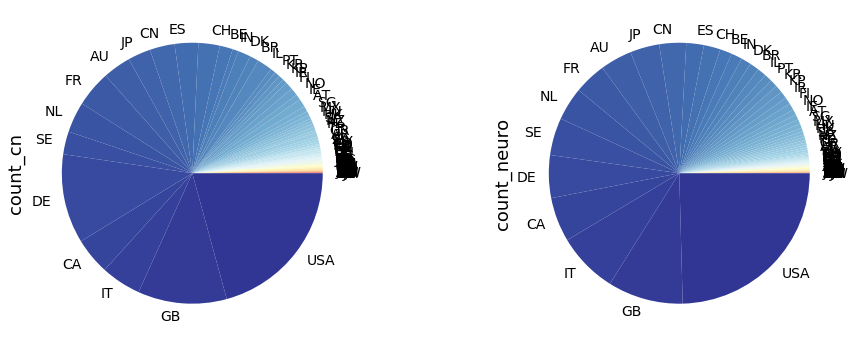

In [11]:
%matplotlib inline
df[['count_cn','count_neuro']] \
    .sort_values(by=['count_neuro','count_cn']) \
    .plot(kind='pie', subplots=True, figsize=(16, 6),legend=False,cmap=plt.get_cmap("RdYlBu"))

### Sort by Computational Neuroscience output

In [12]:
df.sort_values(by='count_cn',ascending=False).head(10)

,name,count_cn,count_neuro,region,cn vs neuro,cn vs world,neuro vs world,cn vs neuro vs world
alpha-2,,,,,,,,
USA,USA,5531,98517,Americas,5.614259,28.692224,28.179517,101.819432
DE,Germany,2951,21224,Europe,13.904071,15.308399,6.070851,252.162302
GB,UK,2936,37401,Europe,7.850057,15.230586,10.698074,142.367554
IT,Italy,1327,30139,Europe,4.402933,6.883851,8.620872,79.850984
CA,Canada,1212,22068,Americas,5.492115,6.287285,6.312267,99.604241
FR,France,1196,15980,Europe,7.484355,6.204285,4.570873,135.735233
NL,Netherlands,1012,16510,Europe,6.129618,5.249780,4.722473,111.165910
AU,Australia,926,15748,Oceania,5.880112,4.803652,4.504512,106.640892
CN,China,823,13302,Asia,6.187040,4.269337,3.804865,112.207292


### Sort by Neuroscience output

In [13]:
df.sort_values(by='count_neuro',ascending=False).head(10)

,name,count_cn,count_neuro,region,cn vs neuro,cn vs world,neuro vs world,cn vs neuro vs world
alpha-2,,,,,,,,
USA,USA,5531,98517,Americas,5.614259,28.692224,28.179517,101.819432
GB,UK,2936,37401,Europe,7.850057,15.230586,10.698074,142.367554
IT,Italy,1327,30139,Europe,4.402933,6.883851,8.620872,79.850984
CA,Canada,1212,22068,Americas,5.492115,6.287285,6.312267,99.604241
DE,Germany,2951,21224,Europe,13.904071,15.308399,6.070851,252.162302
SE,Sweden,755,18558,Europe,4.068326,3.916585,5.308276,73.782602
NL,Netherlands,1012,16510,Europe,6.129618,5.249780,4.722473,111.165910
FR,France,1196,15980,Europe,7.484355,6.204285,4.570873,135.735233
AU,Australia,926,15748,Oceania,5.880112,4.803652,4.504512,106.640892


## Lollipop graphs

In [14]:
my_range=range(1,len(df.index)+1)

# total count
df['count'] = df['count_cn']+df['count_neuro']
# persist the sort
df = df.sort_values(by=['count_neuro','count_cn'])

def apply_alpha(arr_img,alpha=1.):
    """Helper method to apply an alpha to a numpy array image"""
    new_arr_img = np.zeros(shape=(arr_img.shape[0],arr_img.shape[1],4),dtype=arr_img.dtype)
    for i,m in enumerate(arr_img):
        for j,n in enumerate(m):
            new_arr_img[i][j] = np.append(arr_img[i][j],alpha)
    return new_arr_img

### main code block

In [58]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
from matplotlib.ticker import FormatStrFormatter,ScalarFormatter
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
plt.rcParams.update({'font.size': 10})

def plot_lollipop(ordered_df,figsize=(10,10),log=True,hlines=False,
                  zoom_factor=3,num_in_zoom=3,indices=None,
                 labels=None,bold_labels=None):
    %matplotlib inline
    alpha=1
    my_range=range(0,len(ordered_df.index))
    
    neuro_max_lim = ordered_df['count_neuro'].max()
    cn_max_lim = ordered_df['count_cn'].max()
    if not log:
        neuro_max_lim +=100
        cn_max_lim+=10
    factor = neuro_max_lim/cn_max_lim
    
    # Change color if in Africa
    my_size=np.where(ordered_df['region']=='Africa', 40, 40)
    my_color=np.where(ordered_df['region']=='Africa', 'orange', 'skyblue')
    indx_africa = np.where(my_color=='orange')[0][0]
    indx_row = np.where(my_color=='skyblue')[0][0]
    africa = ordered_df[ordered_df['region']=='Africa']['count_neuro'].head(1)
    row = ordered_df[ordered_df['region']!='Africa']['count_neuro'].head(1)
    
    fig,ax = plt.subplots(1,1,figsize=figsize,sharey=True)
    
    # create zooms
    if indices is None:
        indices = [0,'South Africa',-1]
    locs = ['upper left','center right', 'lower right']
    axins = []
    for i in range(len(indices)):
        if i<len(locs):
            loc=locs[i]
        else:
            loc='best'
        axins.append(zoomed_inset_axes(ax, zoom_factor, loc=loc))
    
    if log:
        for i, ax_i in enumerate([ax]+axins):
            ax_i.set_xscale('log')
    
    # do some formatting of the axis before possible duplication with twiny()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    cols = {'count_cn':"Computational Neuroscience",'count_neuro':"Neuroscience"}

    # plot specific points for legend
    ax_i.scatter([], [], color='skyblue', s=my_size*4, alpha=alpha, marker='o',
               label='Computational Neuroscience')
    ax_i.scatter([], [], color='skyblue', s=my_size*4, alpha=alpha, marker='x',
               label='Neuroscience')
    ax_i.scatter([], [], color='orange', s=my_size*4, alpha=alpha, marker='o',
               label='Africa')
    ax_i.scatter([], [], color='skyblue', s=my_size*4, alpha=alpha, marker='o',
               label='Rest of World')
    
    # because of the zooms, points are plotted multiple times (otherwise 'zoom' views would be empty)
    for i, ax_i in enumerate([ax]+axins):
        # plot computational neuroscience points
        ax_i.scatter(ordered_df['count_cn'], my_range, color=my_color, marker='o', s=my_size*(4 if i>0 else 1), 
                     alpha=alpha, label=None)
    
    
    if not log:
        # create a second axis for the other count
        # set formatting options before 'twiny'
        
        ax.set_xlim([0,cn_max_lim])
        ax.legend(loc='left')
        ax.grid(axis='x')
        ax.set_xlabel(f'Number of Computational Neuroscience Publications')
        ax.autoscale(True)
        
        ax = ax.twiny()
        # use original frame
        ax.set_frame_on(False)
        
    for i, ax_i in enumerate([ax]+axins):
        # plot neuroscience points
        ax_i.scatter(ordered_df['count_neuro'], my_range, color=my_color, marker='x', s=my_size*(4 if i>0 else 1), 
                     alpha=alpha, label=None)
    
    
#     ax.set_xlim([0,neuro_max_lim])

    if hlines:
        # draw connections between "computational neuroscience" and "neuroscience" publications counts
        if log:
            xmin = ordered_df['count_cn']
        else:
            xmin = ordered_df['count_cn']*factor
        xmax = ordered_df['count_neuro']
        for ax_i in [ax]+axins:
            ax_i.hlines(y=my_range, xmin=xmin, xmax=xmax, 
                  color='grey', 
                  alpha=0.3)

    ax.get_xaxis().set_label_position('bottom')
    ax.get_xaxis().set_ticks_position('bottom')
    if log:
        # change scale to 1,10,100,etc. instead of 10^0,10^1,10^2,etc.
        ax.get_xaxis().set_major_formatter(FormatStrFormatter("%.0f"))
        ax.set_xlabel('Number of Publications')
        ax.spines['left'].set_color('none')
        ax.get_yaxis().set_visible(False)
    else:
        # adjust 2nd xaxis a little
        ax.spines['bottom'].set_position(('axes', -0.01*figsize[1]))
        # Add title and axes names
        ax.set_xlabel(f'# Neuroscience Publications')
        ax.set_yticks(my_range)
        ax.set_yticklabels(ordered_df['name']+' ('+ordered_df.index+')')
        ax.set_ylabel('Country Code')
        ax.get_yaxis().set_visible(True)
   
    
    l = ax.legend(bbox_to_anchor=(0., 1., 1., .05), loc='upper center',
                        ncol=4, 
                        mode="expand", 
                        borderaxespad=0.)
    for legend_text in l.get_texts():
        if legend_text.get_text()=='Rest of World':
            plt.setp(legend_text,alpha=0.35)
    l.set_frame_on(False)
    ax.set_ylim([0,my_range[-1]+1])
    ax.set_xlim(0.4) # apply the x-limits
#     ax.grid(axis='x')
#     ax.autoscale(True)

    # zooms
    x_min = 'count_cn'
    x_max = ['count_cn','count_neuro'][0]
    for i, axin in zip(indices,axins):
        if i==0:
            top_x = ordered_df.iloc[-num_in_zoom:]
            top_y = my_range[-num_in_zoom:]
        elif i==-1:
            top_x = ordered_df.iloc[:num_in_zoom]
            top_y = my_range[:num_in_zoom]
        else:
            if type(i) is str:
                i=np.where(ordered_df['name']==i)[0][0]
            adjust = int((num_in_zoom-1)/2)
            top_x = ordered_df.iloc[i-adjust:i+1+adjust]
            top_y = my_range[i-adjust:i+1+adjust]
        x1, x2, y1, y2 = np.min(top_x[x_min]),np.max(top_x[x_max]),np.min(top_y),np.max(top_y)
    #     3.7, 4.6 # specify the limits
        axin.set_xlim(x1-x1/10, x2+x2/4) # apply the x-limits
        axin.set_ylim(y1-1, y2+1) # apply the y-limits

        axin.set_xticks([])
        axin.get_xaxis().set_visible(False)
        axin.set_yticks(top_y)
        y_labels =[]
        size = len(df)+1
        for name, number in zip(top_x['name'],top_y):
            y_labels.append(f'{name}')
        axin.set_yticklabels(y_labels)
        
        for label, x, y, indx in zip(df[df.index.isin(top_x.index)][x_min], 
                               top_x[x_min].values, 
                               top_y,
                               top_x.index.values):
            indx = indx.lower()
            if indx == 'usa':
                indx='us'
            try:
                arr_img = plt.imread(f"famfamfam_flag_icons/png/{indx}.png", format='png')
            except:
                print(indx)
                continue
            axin.annotate(
                label,
                xy=(x, y), xytext=(10, 0),
                textcoords='offset points', ha='left', va='center'
        #         arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
                )

            imagebox = OffsetImage(arr_img, zoom=1)
            imagebox.image.axes = ax
            ab = AnnotationBbox(imagebox, (x, y),
                                xybox=(x, y),
                                xycoords="data",
                                boxcoords="data",
                                pad=0.,
#                                 arrowprops=dict(arrowstyle = '-', connectionstyle='arc3,rad=-0',
#                                                 alpha=0.3)
                                )

            axin.add_artist(ab)
            
            
        if x_min != x_max:
            for label, x, y in zip(df[df.index.isin(top_x.index)][x_max], 
                                   top_x[x_max].values, 
                                   top_y):
                axin.annotate(
                label,
                xy=(x, y), xytext=(-10, 6),
                textcoords='offset points', ha='right', va='center',
                bbox=dict(boxstyle='square,pad=0.2', fc='skyblue', alpha=0.5),
        #         arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
                )

        # link zooms to main axis
        mark_inset(ax, axin, loc1=1, loc2=2, fc="none", ec="0.5")
    
    # add flags
    if bold_labels is None:
        bold_labels = []
    if labels is not None:
        y_max = my_range[-1]+1
        for label in labels:
            if type(label) is str:
                i=np.where(ordered_df['name']==label)[0][0]
            else:
                i=label
                label = ordered_df.iloc[i]['name']
            x = ordered_df.iloc[i]['count_cn']
            y = my_range[i]
            xy = (x-x/20,y)
            xy_offset=(0.4,y) # in data coords
            
            format_option=[
                f"{label} {x:>10g}",
                f"{x:g}"][1]
            
            alpha = 1
            if i not in bold_labels:
                # 35% opacity
                alpha=0.35
            
            # add flag
            indx = ordered_df.iloc[i].name.lower()
            if indx == 'usa':
                indx='us'
            try:
                arr_img = plt.imread(f"famfamfam_flag_icons/png/{indx}.png", format='png')
                arr_img = apply_alpha(arr_img, alpha)
            except:
                print(indx,ordered_df.iloc[i]['name'])
                continue
            else:               
                ax.annotate(
                    label,
                    xy=xy_offset, 
                    xytext=(-15,0),textcoords='offset points', 
                    ha='right', va='center',
                    fontsize='x-large',
                    alpha=alpha,
                    bbox=dict(boxstyle='round,pad=0.2', 
                              fc='skyblue', 
                              alpha=0),
                )
                
                imagebox = OffsetImage(arr_img, zoom=1)
                imagebox.image.axes = ax
                xy = xy
                ab = AnnotationBbox(imagebox, xy,
                                    xybox=xy_offset,
                                    xycoords="data",
                                    pad=0.,
                                    bboxprops=dict(facecolor='none', edgecolor='none'),
                                    arrowprops=dict(arrowstyle = '-', connectionstyle='arc3,rad=-0',
                                                    alpha=0.09)
                                    )
                ax.add_artist(ab)
                ax.annotate(
                    format_option,
                    xy=xy_offset, 
                    xytext=(50,6),textcoords='offset points', 
                    ha='right', va='center',
                    fontsize='x-large',
                    alpha=alpha,
                    bbox=dict(boxstyle='round,pad=0.2', ec='w',
                              fc='skyblue', 
                              alpha=0),
                )

### Graph

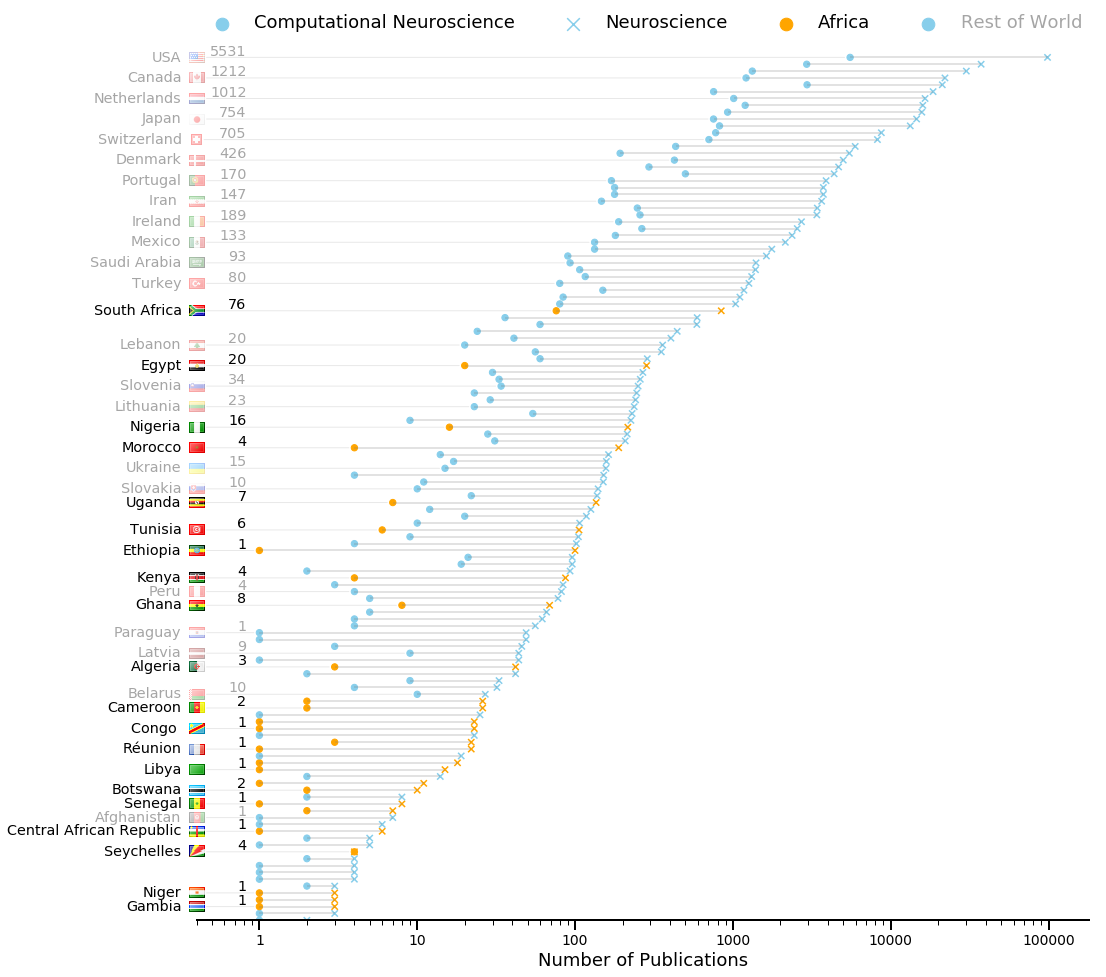

In [59]:
%matplotlib notebook
df = df.sort_values(by=['count_neuro','count_cn'])
temp = df[df['count_neuro']>0]
initial = list(np.where(df['region']=='Africa')[0])
start, stop = 0,temp.index.size
step=3
labels = list(set(list(range(start, stop, step))+initial))

# make it neater by removing some countries 
# (by default all African countries and every 3rd of the others are shown)
remove=['Chile','Colombia','Macao','Mongolia','Philippines','Bosnia and Herzegovina','Sri Lanka',
        'Benin','Armenia','Mauritius','Congo', 'Mali','Monaco','Sudan','Moldova ','Liechtenstein','Montenegro','Liberia',
        'Viet Nam','Malawi','Fiji','Guadeloupe','Gibraltar', 'El Salvador']
tmp_df = df.copy()
tmp_df['i'] = range(len(df))
tmp_df = tmp_df.iloc[labels]
tmp_df = tmp_df[~tmp_df['name'].isin(remove)]
labels = tmp_df['i'].values

plot_lollipop(temp,
              figsize=(16,16),
              hlines=True,
              num_in_zoom=5,
              indices=[],
              labels=labels,
              bold_labels=initial)
plt.savefig("graph.svg", dpi='figure', transparent=True, 
        orientation='portrait', papertype='A4', format=None,
        bbox_inches='tight', pad_inches=0.1, frameon=False)
plt.show()

## Visualise as World Map

In [60]:
from collections import OrderedDict
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.io import show, export_svgs, output_notebook

In [61]:
country_xs = []
country_ys = []
country_names = []
country_cn = []
country_neuro = []

r = requests.get('https://raw.githubusercontent.com/datasets/geo-boundaries-world-110m/master/countries.geojson')
geodata = r.json()
geodata_features = geodata['features']
for i,aCountry in enumerate(geodata_features):
    cName = aCountry['properties']['name']
    if cName == 'Antarctica':
        continue
    alpha2 = aCountry['properties']['wb_a2']
    if alpha2=='US':
        alpha2="USA"
    if alpha2 in df.index.values:
        counts = df.loc[alpha2,['count_cn','count_neuro']]
        count_cn = counts['count_cn']
        count_neuro = counts['count_neuro']
    else:
        count_cn = count_neuro = 0
    
    geometry_type = aCountry['geometry']['type']
    if geometry_type == "MultiPolygon":
        for poly_coords in aCountry['geometry']['coordinates']:
            coords = poly_coords[0]
            country_xs.append(list(map(lambda x:x[0],coords)))
            country_ys.append(list(map(lambda x:x[1],coords)))
            country_cn.append(count_cn)
            country_neuro.append(count_neuro)
            country_names.append(cName)
    else:
        coords = aCountry['geometry']['coordinates'][0]
        country_xs.append(list(map(lambda x:x[0],coords)))
        country_ys.append(list(map(lambda x:x[1],coords)))
        country_cn.append(count_cn)
        country_neuro.append(count_neuro)
        country_names.append(cName)
    
source = ColumnDataSource(
    data = dict(
        x=country_xs,
        y=country_ys,
        name=country_names,
        count_cn=country_cn,
        count_neuro=country_neuro,
    )
)
output_notebook()

Loading BokehJS ...

In [62]:
high = df['count_cn'].max()
yticks = np.logspace(0,np.log1p(high),3,base=np.e)
yticklabels = [f"{ytick:.0f}" for ytick in yticks]
yticklabels[0] = '0'
yticklabels[-1] = str(high)
yticklabels

['0', '74', '5531']

In [86]:
from bokeh.models import ColorBar, HoverTool, LogColorMapper, LinearColorMapper, LogTicker
from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label
from matplotlib import colors
# number of distinct colors (excluding white)
n = 100
cm = plt.get_cmap('Greens',n)
# convert to hex
palette = [colors.rgb2hex(cm(i)) for i in range(cm.N)]
palette.insert(0,'#ffffff')

TOOLS="pan,wheel_zoom,box_zoom,reset,hover,save"
p = figure(height=400,width=1000, toolbar_location='above')
color_mapper = LogColorMapper(palette=palette, low=0, high=high) # includes 0

p.patches('x', 'y', source=source,
          fill_color={'field': 'count_cn', 'transform': color_mapper},
          fill_alpha=1, line_color="black", line_width=0.5,
          hover_fill_alpha = 0.5)

hover = HoverTool(tooltips=[
    ('Name', '@name'),
    ('Computational Neuroscience', '@count_cn'),
    ('Neuroscience', '@count_neuro'),
                                   ])

p.add_tools(hover)

cbar_height = 150
color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(), 
                     border_line_color=None, 
                     label_standoff=14,major_label_text_align='right',
                     major_tick_line_color='black',
                     height=cbar_height, width=50, location=(35,10))
p.add_layout(color_bar)

# labels for the colorbar won't be added because color_mapper includes 0, and this is easier to customise
y_base = 8
dheight = cbar_height/(len(yticklabels)-1)
for i,yticklabel in enumerate(yticklabels):
    color_bar_axis = Label(x=93, y=y_base+i*dheight, x_units='screen', y_units='screen',
                         text='- '+yticklabel, text_font='sans serif', text_font_size=f"{settings.BIGGEST_SIZE+8}pt")
    p.add_layout(color_bar_axis)

p.outline_line_color = None
p.xaxis.visible = False
p.yaxis.visible = False 
p.xgrid.visible = False
p.ygrid.visible = False
p.background_fill_color = None
p.border_fill_color = None
show(p)

### Save map

In [64]:
!conda install phantomjs -y

Solving environment: done

# All requested packages already installed.



In [87]:
p.output_backend = "svg"
export_svgs(p, filename="choropeth.svg")

['choropeth.svg']

### Combine figures

In [88]:
import svgutils.compose as sc
from IPython.display import SVG # /!\ note the 'SVG' function also in svgutils.compose
sc.Figure("1000", "900", 
    sc.Panel(sc.SVG("choropeth.svg").scale(.6).move(410,585)),
    sc.Panel(sc.SVG("graph.svg").scale(0.9).move(0,0)),
    ).save("figure_1.svg")
SVG('figure_1.svg')